In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time

from scipy.io import loadmat
from scipy.misc import imread
from scipy.misc import imresize
from scipy.ndimage import filters
import matplotlib.image as mpimg

import urllib
%matplotlib inline

In [0]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"], train_size=0.8, random_state=411)
X_train, y_train, X_test, y_test = X_train/255.0, y_train, X_test/255.0, y_test
print X_train.shape, y_train.shape, X_test.shape, y_test.shape

(56000, 784) (56000,) (14000, 784) (14000,)


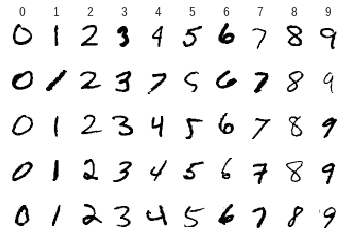

In [40]:
n_samples = 5
n_classes = 10
for number in range(n_classes):
  samples = X_train[y_train==number][:n_samples]
  for sample_idx in range(n_samples):
    index = number + sample_idx * n_classes + 1
    fig = plt.subplot(n_samples,n_classes, index)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.imshow(samples[sample_idx].reshape(28,28))
    if sample_idx == 0: 
      plt.title("{}".format(number))

In [0]:
def one_hot_encode(labels):
  n_out = np.unique(labels).shape[0]
  encoding = np.eye(n_out)
  y = np.array([encoding[int(label)] for label in labels]).reshape(-1, n_out)
  return y

In [52]:
y_train_one_hot = one_hot_encode(y_train)
print y_train_one_hot[:5]

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [0]:
def cross_entropy_with_softmax(X, y, theta, reg_const=0.01, gradient=False):
    n_samples = X.shape[0]
    
    weights = np.zeros_like(theta)
    weights[1:, :] = theta[1:, :]
    
    logits = np.matmul(X, theta)
    probs = softmax(logits)

    if gradient:
        return (1.0/n_samples) * np.matmul(X.T, (probs - y)) + reg_const * weights
    else:
        return -np.sum(y * np.log(probs))/n_samples + (0.5)*reg_const*np.sum(np.matmul(weights.T, weights))

In [0]:
def evaluation(X, y_true, theta, reg_const=0.01, cost_fn=cross_entropy_with_softmax, activation='softmax'):
    n_samples = X.shape[0]
    
    if activation =='logistic':
        probs = sigmoid(np.dot(X, theta))
        y_pred = np.round(probs)
        n_correct = np.equal(y_pred, y_true).sum()
        
    elif activation == 'softmax':
        probs = softmax(np.dot(X, theta))
        y_pred = np.argmax(probs, axis=1)
        n_correct = np.equal(y_pred, np.argmax(y_true, axis=1)).sum()
        
    elif activation == 'linear':
        y_pred = np.dot(X, theta)
        results = y_true * y_pred
        n_correct = (results > 0).astype(int).sum()
    else:
        assert ValueError
    
    accuracy = float(n_correct) / float(n_samples)
    
    return accuracy, cost_fn(X, y_true, theta, reg_const)

In [0]:
def exp_decay(step, init_alpha=0.1, min_alpha=0.001, k=0.5):
    lrate = np.max([min_alpha, min_alpha * exp(-k*step)])
    return lrate

In [0]:
def nesterov_descent(train, validation, theta, 
                     init_alpha=0.1, decay_rate=0.5, min_alpha=0.003, beta=0.9, reg_const = 0.001, 
                     n_steps=10000, steps_until_eval=100, cost_fn=cross_entropy_with_softmax, activation='softmax'):
    global step
    X = train[0]
    y_true = train[1]
    n_samples = X.shape[0]
    

    momentum = np.zeros_like(theta)
    
    best_theta = theta
    best_metric = 0.0
    best_train_acc = 0.0
    best_valid_acc = 0.0
    evals_since_last_best = 0

    while step < n_steps:
        theta_ahead = theta + beta * momentum
        
        gradients = cost_fn(X, y_true, theta_ahead, reg_const, gradient=True)
        learn_rate = exp_decay(step, init_alpha, min_alpha, k=decay_rate)
        momentum = beta * momentum - learn_rate * gradients
        theta += momentum
        
        step += 1
        
        if (step) % steps_until_eval == 0:
            train_accuracy, train_cost = evaluation(train[0], train[1], theta, 
                                                    reg_const, cost_fn, 
                                                    activation)
            
            validation_accuracy, validation_cost = evaluation(validation[0], validation[1], theta, 
                                                              reg_const, cost_fn, 
                                                              activation)
            
            print "Step: {}".format(step)
            print "Training Accuracy: {}, Training Cost: {}".format(train_accuracy, train_cost) 
            print "Validation Accuracy: {}, Validation Cost: {}".format(validation_accuracy, validation_cost) 
            
            # Implementation of early stopping           
            
            validation_metric = validation_accuracy * (1/(validation_cost + 1**-10))
            
            if validation_metric > best_metric:
                evals_since_last_best = 0
                
                best_theta = theta
                best_metric = validation_metric
                
                best_train_acc = train_accuracy              
                best_valid_acc = validation_accuracy
            
                print "Best Accuracy: {}, Best Cost: {}".format(validation_accuracy, validation_cost)
                
            elif evals_since_last_best > 10:
                print("Stopped early")
                break
            else:
                evals_since_last_best += 1
                
            print "Best Metric: {}".format(best_metric)
                    
    pd.DataFrame(best_theta).to_csv("models/best_theta-{:.3f}-{:.3f}.csv".format(best_train_acc,  
                                                                                best_valid_acc))
    return best_theta